In [1]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import pandas as pd
import seq_generator
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import json
from keras.preprocessing import image
import matplotlib.pyplot as plt


pars = json.load(open("tuner_run/best_hps.json"))

train_ds , val_ds = seq_generator.get_train_and_val(batch_size=128)
cnn = tf.keras.models.load_model("cnn_base/model")

def build_model(hps):


    inputs = tf.keras.Input([5,260,260,3])
    x = layers.TimeDistributed(cnn)(inputs)

    drop1 = hps["drop1"]

    x = layers.TimeDistributed( layers.Dropout(drop1), name = "drop1") (x)

    hidden_units =  hps["hidden_units"]

    if hps["rnn"] == "lstm":
        x = layers.LSTM(hidden_units, name = "lstm")(x)
    else:
        x = layers.GRU(hidden_units, name = "gru") (x)

    drop2 = hps["drop2"]
    x = layers.Dropout(drop2,name ="drop2")(x)

    outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

    learning_rate = hps["lr"]

    model = tf.keras.Model(inputs,outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_model(pars)
model.load_weights("tuner_run/warm.ckpt")

c:\Users\ual\.conda\envs\felix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataframe, Model and DS To Test on

In [2]:
bs = 64
ds = seq_generator.get_train_and_val(batch_size=bs)[1]

df = seq_generator.get_df()[1]

func = lambda s: s[s.find("images/")+7:]
df["local_path"] = np.array([[f"../seq_data/{s}/{func(i)}"for i in c] for c,s in zip(df.Paths,df.ds_type)]).tolist()

DF and Ds the Same

In [3]:
# n =  10
# rn = np.random.choice(range(bs),n,replace=False)

# for i,(seqs,labels) in enumerate(tfds.as_numpy(ds.take(2))):
    
#     fig, ax = plt.subplots(10,2,figsize = (4,10)) 


#     d = df.iloc[i*bs:i*bs + bs].iloc[rn]
#     seqs = seqs[rn]

#     for j in range(n):
#         ax[j,0].imshow(plt.imread(d.local_path.iloc[j][0]))
#         ax[j,1].imshow(seqs[j][0])
#         ax[j,1].axis("off")
#         ax[j,0].axis("off")

#     plt.show()

In [4]:
batch_size = 64


df.loc

Okay, the images align

In [5]:
#preds = model.predict(ds,verbose=1)

70/70 [==============================] - 681s 10s/step


In [6]:
df = df.iloc[:len(preds)].copy()
labels = (df.view_direction == "Sideways").map(int).values

In [7]:
(labels == np.argmax(preds,1)).mean()

0.8997767857142858

In [30]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

bce(labels,preds[:,1]).numpy()

df["preds"] = preds.tolist()
df["p"] =  np.argmax(preds,1)
df["l"] = labels
df.reset_index().to_feather("tmp/losses_cnn1.df")

In [31]:
df["losses"] = bce(np.expand_dims(labels,1),np.expand_dims(preds[:,1],1)).numpy()
df.sort_values('losses',ascending=False,inplace= True)

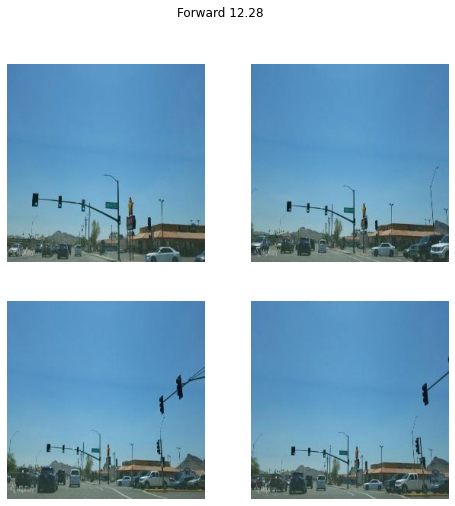

In [40]:
def plot_row(row):
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    keys = row['local_path']
    np.random.shuffle(keys)
    for i,a in enumerate(ax.flatten()):
        try:
            a.imshow(plt.imread(keys[i]))
        except:
            pass
        a.axis('off')
    plt.suptitle(f"{row['view_direction']} {row['losses'] :.2f}")
    plt.show()

plot_row(df.iloc[0])

In [28]:
(5 < df.losses).sum()

291

In [39]:
high_loss = df[(5 < df.losses) ]
import tqdm
for n in tqdm.tqdm(range(len(high_loss))):

    row = high_loss.iloc[n]
    fig, ax = plt.subplots(2,2,figsize=(12,12))
    keys = row['local_path']
    #np.random.shuffle(keys)
    for i,a in enumerate(ax.flatten()):
        try:
            a.imshow(plt.imread(keys[i]))
        except: pass
        a.axis('off')
    plt.suptitle(f"{row['view_direction']} {row['losses'] :.2f}")
    path = "tmp/cnn1_val_highest_loss/" +  str(high_loss.index[n]) + ".jpg"
    plt.savefig(path)
    plt.close()

100%|██████████| 291/291 [00:59<00:00,  4.90it/s]


In [33]:
(df.p != df.l).mean()

0.10022321428571429

In [37]:
df.loc[(df.p != df.l),"losses"].describe()

count    449.000000
mean       7.257858
std        4.023769
min        0.705344
25%        3.074840
50%        8.328044
75%       11.318254
max       12.282964
Name: losses, dtype: float64